# Problem Statement: **Threat Classification for AtliQ Wildlife Reserve**

### Welcome to the AtliQ Wildlife Reserve, a sanctuary where technology helps preserve wildlife. You are tasked with developing AI systems to monitor, classify, and predict behaviors of animals in the sanctuary.


**References:**

* PyTorch Dataset and Dataloader [link](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
* Seaborn Heatmaps [link](https://seaborn.pydata.org/generated/seaborn.heatmap.html)


Imports and CUDA

In [92]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Let's do some revision first!

**Problem1.** AtliQ Warehouse

Your task is to define a simple neural network that will predict whether AtliQ's warehouses are running an optimal stock level for a given product (binary classification). The neural network should include:

* An input layer of size 128 (representing features such as sales trends, regional demand, and supplier reliability).
* Two hidden layers, each with 64 neurons.
* An output layer that predicts the stock status (1 for optimal, 0 for not optimal).


**Hint:** Use nn.Sequential to define the network.

In [93]:
model = nn.Sequential(
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

# Print the model structure
print(model)

Sequential(
  (0): Linear(in_features=128, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=2, bias=True)
)




---



**Problem2.** Sales data at AtliQ

AtliQ's data analytics team has provided sales data in NumPy format for your AI models. The data,

` data = np.array([1, 2, 3, 4, 5])`,

 represents product sales in a given week. Your task is to:

Convert this NumPy array into a PyTorch tensor of type float32.


In [94]:
# Create a NumPy array
data = np.array([1, 2, 3, 4, 5])

# Convert the NumPy array to a PyTorch tensor of type float32
tensor_data = torch.tensor(data)

# Print the tensor
print(tensor_data)

tensor([1, 2, 3, 4, 5])




---



**Problem3.** Customer Classification at AtliQ

AtliQ's marketing team is running an AI model to classify customers into 3 distinct segments based on purchasing behavior. Your task is to:

* Simulate raw logits from the model's output.
* Generate random target labels for a 3-class classification task
* Compute the classification loss using nn.CrossEntropyLoss

**Hint**: Use torch.randint() for generating random target labels and nn.CrossEntropyLoss() for the loss function.

In [95]:
logits = torch.tensor([[1.0, 2.0, 0.5], [1.5, 0.2, 1.7], [0.4, 0.8, 2.1]], dtype=torch.float32)

labels = torch.tensor([1, 2, 0], dtype=torch.long)

# Define the CrossEntropyLoss function
loss_fun = nn.CrossEntropyLoss()

# Compute the loss
loss = loss_fun(logits, labels)

print(f"Cross-Entropy Loss: {loss.item():.4f}")

Cross-Entropy Loss: 1.0845




---



### **Task:** Habitat Threat Detector

In the sanctuary, camera drones monitor animal habitats for threats like poaching activities or habitat damage. Your task as an AI Engineer is to build an AI system to detect whether an image shows a threat from the provided dataset **(habitat_images_codebasics_DL.csv)**.

**Dataset Overview**

The dataset **habitat_images_codebasics_DL.csv** contains the following features:

* Image Brightness (float): Represents how bright or dark the image is.
* Movement Intensity (float): Measures activity detected in the image.
* Number of Shapes Detected (integer): Indicates potential objects in the image.
* Noise Level (float): A measure of distortions in the image.
* Threat Label (0 or 1): 0 for no threat, 1 for a threat.

**Step 1:** Load and Split the Dataset



In [96]:
df = pd.read_csv("../datasets/habitat_images.csv")
df.head()
# # Separate input features and labels
X = df[['Image Brightness', 'Movement Intensity', 'Number of Shapes Detected', 'Noise Level']]
y = df['Threat Label']



---



**Step 2:** Normalize the input feature

In [97]:
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))



---



**Step3:** Convert to PyTorch tensors


In [98]:
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)  # Reshape to match the model output



---



**Step4**: Perform an **70%-30%** train-validation split.

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)



---



**Step5**: Create DataLoader for batch processing

In [100]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)



---



**Step 6:** Define the Neural Network

* Input layer with 4 features.
* One hidden layer with 8 neurons (ReLU activation).
* Output layer with 1 neuron (Sigmoid activation for binary classification).

In [101]:
class ThreatDetector(nn.Module):
    def __init__(self):
        super(ThreatDetector, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(4, 8),    # Input: 4 features, Hidden layer: 8 neurons
            nn.ReLU(),          # Activation: ReLU
            nn.Linear(8,1),    # Output: 1 neuron
            nn.Sigmoid()        # Activation: Sigmoid (for binary classification)
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model
model = ThreatDetector()




---



**Step7**: Define Loss and Optimizer

* Optimizer: Adam
* Loss: BCE Loss
* Learning rate: 0.01

In [102]:
# Binary Cross-Entropy Loss
BCE_loss = nn.BCELoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)



---



**Step 8**: Train the Neural Network

* Train the model for 20 epochs

In [103]:
def train_model(model, train_loader, BCE_loss, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0  # Initialize loss for this epoch

        for X_batch, y_batch in train_loader:
            # Forward pass
            logits = model(X_batch).squeeze()  # Ensure shape matches y_batch
            loss = BCE_loss(logits, y_batch.squeeze())

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Print every 10 epochs
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")


# Train the model
train_model(model, train_loader, BCE_loss, optimizer, epochs=1000)


Epoch 100/1000, Loss: 0.0978
Epoch 200/1000, Loss: 0.0386
Epoch 300/1000, Loss: 0.0216
Epoch 400/1000, Loss: 0.0078
Epoch 500/1000, Loss: 0.0045
Epoch 600/1000, Loss: 0.0028
Epoch 700/1000, Loss: 0.0019
Epoch 800/1000, Loss: 0.0012
Epoch 900/1000, Loss: 0.0009
Epoch 1000/1000, Loss: 0.0007




---



**Step 9:** Evaluate the Model

* Calculate the accuracy and loss on a test dataset.
* Use a confusion matrix to evaluate the system’s performance.

Accuracy: 1.00


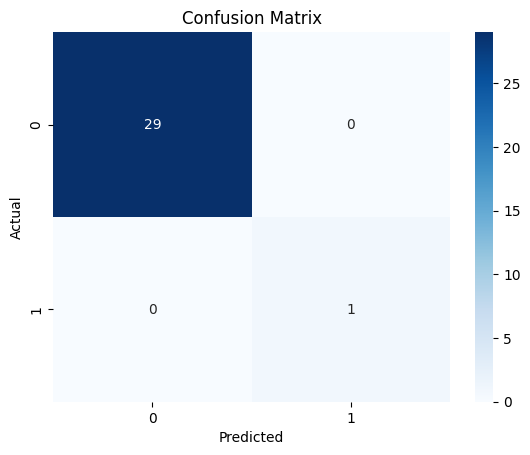

In [104]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            all_preds.extend((outputs >= 0.5).int().tolist())  # Convert predictions to binary (threshold = 0.5)
            all_labels.extend(y_batch.squeeze().tolist())

    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.2f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_loader)



---

